Exemple de réseau convolutionnel avec PyTorch. On construit des données simples d'images représentant des disques et des carrés puis on entraîne un petit réseau à trois couches pour qu'il distingue les deux classes.

Tout d'abord on importe les librairies PyTorch, NumPy et MatplotLib :

In [20]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

Fonction pour créer les données images : la fonction CreateData renvoie un tenseur I de taille Nx1x32x32 contenant les images et un vecteur L contenant les classes (0 ou 1)

In [21]:
def CreateData(N):
    M = 32
    I = np.zeros([N,1,M,M])
    L = np.zeros(N)
    ech = np.linspace(0,1,M)
    X,Y = np.meshgrid(ech,ech)
    for k in range(N):
        r = 1/8+np.random.rand(1)/8 # random radius
        c = r+(1-2*r)*np.random.rand(2,1) # random center position
        if np.random.rand(1)<.5:
            # circle
            I[k,0,:,:] = ((X-c[0])**2+(Y-c[1])**2) < r**2
            L[k] = 0
        else:
            # square
            I[k,0,:,:] = np.maximum(np.abs(X-c[0]),np.abs(Y-c[1])) < r
            L[k] = 1
    return I, L

On crée 2500 images et on affiche les 5 premières :

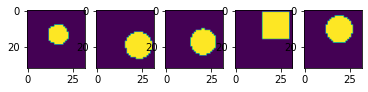

In [40]:
N = 2500
I, L = CreateData(N)
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(np.squeeze(I[k,0,:,:]))

plt.show()

On convertit les données en tenseurs PyTorch :

In [42]:
I = torch.from_numpy(I.astype('float32'))
L = torch.from_numpy(L.astype('long'))

On sépare les données en deux parties : données d'entraînement pour les 2400 premières, et données de test pour les 100 dernières :

In [25]:
N = len(L)
batch_size = 100
Ntrain = N-batch_size
Itrain = I[:Ntrain,:,:]
Ltrain = L[:Ntrain]
Itest = I[Ntrain:,:,:]
Ltest = L[Ntrain:]
nbatch = Ntrain//batch_size
print(nbatch)

24


Les nombres batch_size=100 et nbatch=24 signifient que les données d'entraînement seront ensuite séparées en 24 groupes de 100 données. Le réseau sera entraîné successivement sur chaque groupe.

A présent on définit les variables du réseau : deux filtres de convolution fa et fb et une matrice m. On ajoute requires_grad=True pour indiquer qu'on va avoir besoin de calculer le gradient de la fonction de coût par rapport à ces variables.

In [26]:
fa = torch.randn(16,1,5,5,requires_grad=True)
fb = torch.randn(32,16,5,5,requires_grad=True)
m = torch.randn(8*8*32,2,requires_grad=True)

On définit maintenant une fonction pour le réseau. 
Cette fonction correspond au calcul "forward" du réseau : l'entrée 
est supposé être un tenseur I de taille (batch_size,1,32,32), auquel on va appliquer successivement les opérations des différentes couches du réseau.

In [27]:
def mycnn(I):
    # first layer
    out = F.conv2d(I, fa, padding=2)
    out = nn.BatchNorm2d(16, affine=False)(out)
    out = torch.relu(out)
    out = F.max_pool2d(out,2,stride=2)
    # second layer
    out = F.conv2d(out, fb, padding=2)
    out = nn.BatchNorm2d(32, affine=False)(out)
    out = torch.relu(out)
    out = F.max_pool2d(out,2,stride=2)
    # flatten
    out = out.reshape(out.size(0), -1)
    # third layer
    out = out.mm(m)
    return out

On passe à présent à l'entraînement du réseau :

In [28]:
niter = 10
lossrec = np.zeros(niter*nbatch)
learning_rate = 1e-1
optimizer = torch.optim.Adam([fa,fb,m], lr=learning_rate)
for t in range(niter):
    for k in range(nbatch):
        Itraink = Itrain[range(k*batch_size,(k+1)*batch_size),:]
        Ltraink = Ltrain[range(k*batch_size,(k+1)*batch_size)]
        optimizer.zero_grad()
        out = mycnn(Itraink)
        loss = nn.CrossEntropyLoss()(out,Ltraink)
        loss.backward()
        optimizer.step()
        lossrec[k+t*nbatch] = loss.item()
        if k % 10 == 0:
            print(t,k,lossrec[k+t*nbatch])

0 0 15.536142349243164
0 10 40.6625862121582
0 20 23.957874298095703
1 0 16.672067642211914
1 10 6.815831184387207
1 20 6.409959316253662
2 0 3.555882453918457
2 10 2.22875714302063
2 20 0.43674442172050476
3 0 0.14952722191810608
3 10 0.02503778226673603
3 20 0.002411824883893132
4 0 0.03963140770792961
4 10 0.00031532428693026304
4 20 0.0008528649341315031
5 0 0.0011163322487846017
5 10 7.228120921354275e-06
5 20 4.2544183088466525e-05
6 0 0.0012010387144982815
6 10 4.131545210839249e-06
6 20 0.0032122426200658083
7 0 1.2993793063742487e-07
7 10 7.543415904365247e-06
7 20 0.0001854917936725542
8 0 1.3386899126999197e-06
8 10 2.2217245714273304e-05
8 20 0.00010298575944034383
9 0 5.841200163558824e-07
9 10 9.889427019516006e-06
9 20 4.417059972183779e-05


On affiche les valeurs de la fonction coût en fonction des itérations :

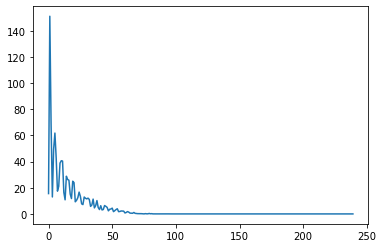

In [29]:
plt.plot(lossrec)
plt.show()

Le réseau est entraîné ; à présent on évalue les performances, d'abord on calcule le nombre d'erreurs sur les données d'apprentissage ; ensuite sur les données de test :

In [30]:
perm = torch.randperm(Ntrain)
idx = perm[:100]
Itrain_eval = Itrain[idx,:]
Ltrain_eval = Ltrain[idx]
out = mycnn(Itrain_eval)
values, indices = torch.max(out, 1)
print("taux d'erreur sur données d'apprentissage:",(indices!=Ltrain_eval).float().mean().item())

taux d'erreur sur données d'apprentissage: 0.0


In [31]:
out = mycnn(Itest)
values, indices = torch.max(out, 1)
print("taux d'erreur sur données de test:",(indices!=Ltest).float().mean().item())

taux d'erreur sur données de test: 0.019999999552965164


Affichage des 16 filtres de la première couche :

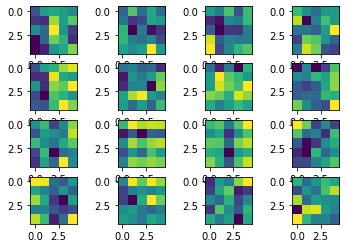

In [33]:
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.imshow(fa[k,0,:,:].data.numpy())

Affichage des sorties des 16 filtres de la première couche sur une des images

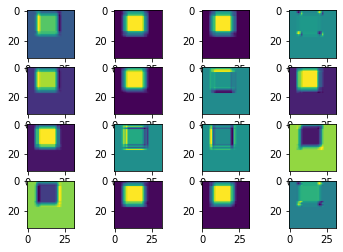

In [35]:
J = np.reshape(I[5,:,:,:],[1,1,32,32])
outJ = F.conv2d(J, fa, padding=2)
for k in range(16):
    plt.subplot(4,4,k+1)
    plt.imshow(outJ[0,k,:,:].data.numpy())

On va tester le réseau sur la superposition d'une image de carré et de disque.

On crée d'abord un telle image et on l'affiche :

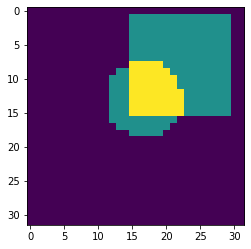

In [43]:
J = np.reshape(I[list(L).index(0),:,:,:]+I[list(L).index(1),:,:,:],[32,32])
plt.imshow(J.data.numpy())
plt.show()

Puis on applique le réseau et on affiche la sortie :

In [44]:
J = np.reshape(J,[1,1,32,32])
outJ = mycnn(J)
outJ

tensor([[19.4538, 18.1218]], grad_fn=<MmBackward>)

Pour retrouver une interprétation en terme de probabilités d'appartenance à chacune des deux classes, il faut appliquer la fonction *softmax* à `outJ`. Ceci vient du fait que la fonction `CrossEntropyLoss` utilisée pour l'entraînement du réseau, revient à composer un *softmax* (pour convertir les valeurs en probabilités, et un calcul d'entropie croisée.

In [45]:
outJ.softmax(dim=1)

tensor([[0.7912, 0.2088]], grad_fn=<SoftmaxBackward>)